# FLEX scRNA pilot

## Merge and plot QC metrics
- Author: Jacopo Umberto Verga, Kane Foster
- Date: 26/March/2025

After running the doublets detection methods, I am going to:
- Load the samples and merge them in one single anndata file
- Integrate doublets results
- Integrate metadata
- Plot QC metrics
- Plot UMAPS to check batch effect

In [1]:
import os
import anndata as ad
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from IPython.display import Markdown

warnings.filterwarnings('ignore')

In [4]:
def list_files(input_dir):
    samples = os.listdir(input_dir)
    return samples

def create_out_dir(out_dir, sample_name):
    output_dir = out_dir + '/' + sample_name + '/QC/'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    return output_dir

def load_sample(file_path):
    adata=sc.read_10x_h5(file_path+'/sample_filtered_feature_bc_matrix.h5')
    adata.var_names_make_unique()
    adata.obs['og_barcodes'] =  adata.obs_names
    return adata

def sample_qc_metrics(adata):
    # mitochondrial genes, "MT-" for human, "Mt-" for mouse
    adata.var["mt"] = adata.var_names.str.startswith("MT-")
    # ribosomal genes
    adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
    # hemoglobin genes
    adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")\
    # ig genes
    adata.var['ig'] = adata.var_names.str.startswith(("IGK","IGH","IGL",))
    sc.pp.calculate_qc_metrics(
        adata,
        qc_vars=["mt", "ribo", "hb","ig"],
        inplace=True,
        log1p=True)
    return adata

def add_scrublet(out_dir,adata,file_path):
    scrublet_path=out_dir + '/' + file_path + '/Scrublet/' + file_path + '_Scrublet_results.csv'
    scrublet=pd.read_csv(scrublet_path,index_col=[0])
    adata.obs['Scrublet_score'] = scrublet['doublet_scores']
    adata.obs['Scrublet_doublet'] = scrublet['predicted_doublets'].astype(str)
    return adata
    
def add_scds(out_dir,adata,file_path):
    scds_path=out_dir + '/' + file_path + '/SCDS/' + file_path + '_SCDS_results.csv'
    scds=pd.read_csv(scds_path,index_col=[0])
    adata.obs['SCDS_cxds_score'] = scds['cxds_score']
    adata.obs['SCDS_bcds_score'] = scds['bcds_score']
    adata.obs['SCDS_hybrid_score'] = scds['hybrid_score']
    return adata

def add_scdblfinder(out_dir,adata,file_path):
    scdf_path=out_dir + '/' + file_path + '/scDblFinder/' + file_path + '_scDblFinder_results.csv'
    scdf=pd.read_csv(scdf_path,index_col=[0])
    adata.obs['scDblFinder_score'] = scdf['scDblFinder.score']
    adata.obs['scDblFinder_class'] = scdf['scDblFinder.class']
    return adata

def load_update_samples(input_dir, file_path, out_dir, doublets=True):
    adata = load_sample(input_dir+file_path)
    adata = sample_qc_metrics(adata)
    if doublets:
        adata = add_scrublet(out_dir,adata,file_path)
        adata = add_scds(out_dir,adata,file_path)
        adata = add_scdblfinder(out_dir,adata,file_path)
    return adata

def load_all_and_merge(input_dir,out_dir,doublets=True,exclude=['']):
    files = list_files(input_dir)
    adatas = {}
    for file_path in files:
        if file_path in exclude:
            continue
        adatas[file_path]=load_update_samples(input_dir,file_path,out_dir,doublets)
    adata = ad.concat(adatas, label="sample_id")
    adata.obs_names_make_unique()
    # ig pct thr
    adata.obs['thr'] = (adata.obs['pct_counts_ig'] > 1).astype(str)
    return adata

## Pre-Doublets QC

In [5]:
adata = load_all_and_merge('../data/cellranger/','../out',doublets=False)
adata

AnnData object with n_obs × n_vars = 97451 × 18129
    obs: 'og_barcodes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_ig', 'log1p_total_counts_ig', 'pct_counts_ig', 'sample_id', 'thr'

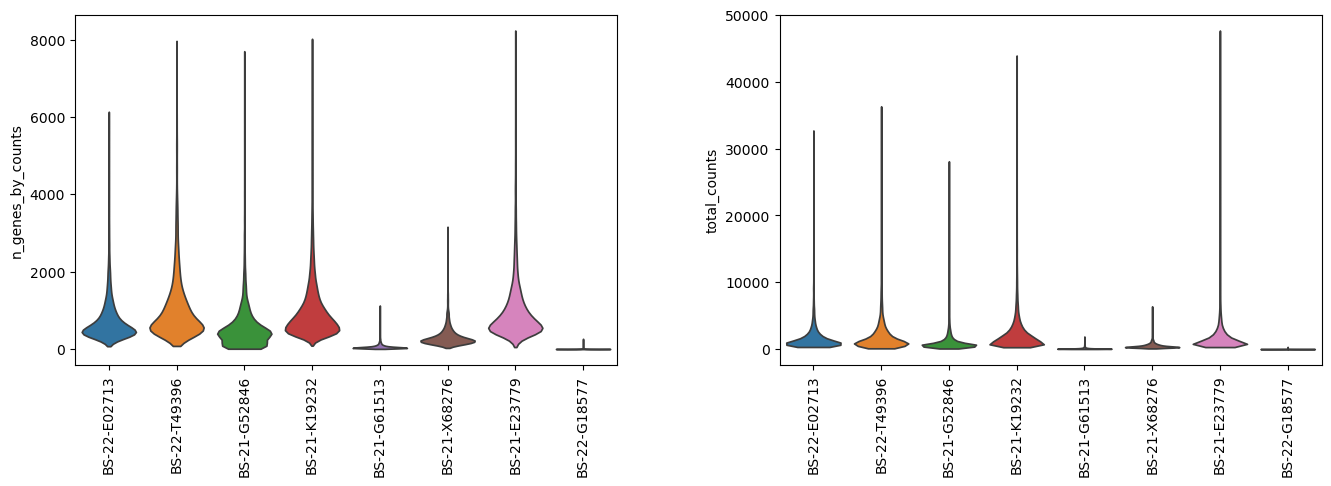

In [6]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts"],
    'sample_id',
    multi_panel=False,stripplot=False,rotation=90
)

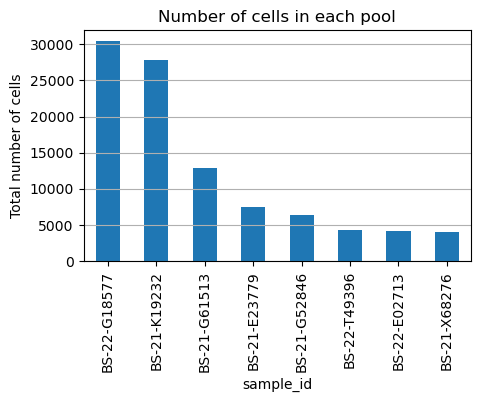

In [7]:
plt.figure(figsize=(5,3))
adata.obs['sample_id'].value_counts().plot.bar()
plt.ylabel('Total number of cells')
plt.grid(axis='y') 
plt.title('Number of cells in each pool')

plt.show()

## QC with doublets on high count samples

In [8]:
adata = load_all_and_merge('../data/cellranger/','../out',exclude=['BS-22-G18577','BS-21-G61513'])
meta = adata.obs
adata

AnnData object with n_obs × n_vars = 54209 × 18129
    obs: 'og_barcodes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_ig', 'log1p_total_counts_ig', 'pct_counts_ig', 'Scrublet_score', 'Scrublet_doublet', 'SCDS_cxds_score', 'SCDS_bcds_score', 'SCDS_hybrid_score', 'scDblFinder_score', 'scDblFinder_class', 'sample_id', 'thr'

In [9]:
total = len(adata.obs_names)

In [68]:
Markdown(f"""

## Cell Numbers:


Average number of cells from each sample:\n
{round(pd.DataFrame(adata.obs['sample_id'].value_counts()).mean(),2).to_list()[0]}


{pd.DataFrame(adata.obs['sample_id'].value_counts()).to_html()}
""")



## Cell Numbers:


Average number of cells from each sample:

9034.83


<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>count</th>
    </tr>
    <tr>
      <th>sample_id</th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>BS-21-K19232</th>
      <td>27784</td>
    </tr>
    <tr>
      <th>BS-21-E23779</th>
      <td>7485</td>
    </tr>
    <tr>
      <th>BS-21-G52846</th>
      <td>6420</td>
    </tr>
    <tr>
      <th>BS-22-T49396</th>
      <td>4304</td>
    </tr>
    <tr>
      <th>BS-22-E02713</th>
      <td>4185</td>
    </tr>
    <tr>
      <th>BS-21-X68276</th>
      <td>4031</td>
    </tr>
  </tbody>
</table>


In [5]:
Markdown(f"""
## QC Plots and metrics

{meta[["n_genes_by_counts", "total_counts", "pct_counts_mt"]].describe().round(1).to_html()}
""")


## QC Plots and metrics

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>n_genes_by_counts</th>
      <th>total_counts</th>
      <th>pct_counts_mt</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>count</th>
      <td>54209.0</td>
      <td>54209.0</td>
      <td>54209.0</td>
    </tr>
    <tr>
      <th>mean</th>
      <td>884.7</td>
      <td>1849.5</td>
      <td>2.6</td>
    </tr>
    <tr>
      <th>std</th>
      <td>753.9</td>
      <td>2315.5</td>
      <td>2.4</td>
    </tr>
    <tr>
      <th>min</th>
      <td>11.0</td>
      <td>94.0</td>
      <td>0.0</td>
    </tr>
    <tr>
      <th>25%</th>
      <td>435.0</td>
      <td>627.0</td>
      <td>1.3</td>
    </tr>
    <tr>
      <th>50%</th>
      <td>658.0</td>
      <td>1098.0</td>
      <td>2.0</td>
    </tr>
    <tr>
      <th>75%</th>
      <td>1070.0</td>
      <td>2147.0</td>
      <td>3.2</td>
    </tr>
    <tr>
      <th>max</th>
      <td>8236.0</td>
      <td>47663.0</td>
      <td>60.2</td>
    </tr>
  </tbody>
</table>


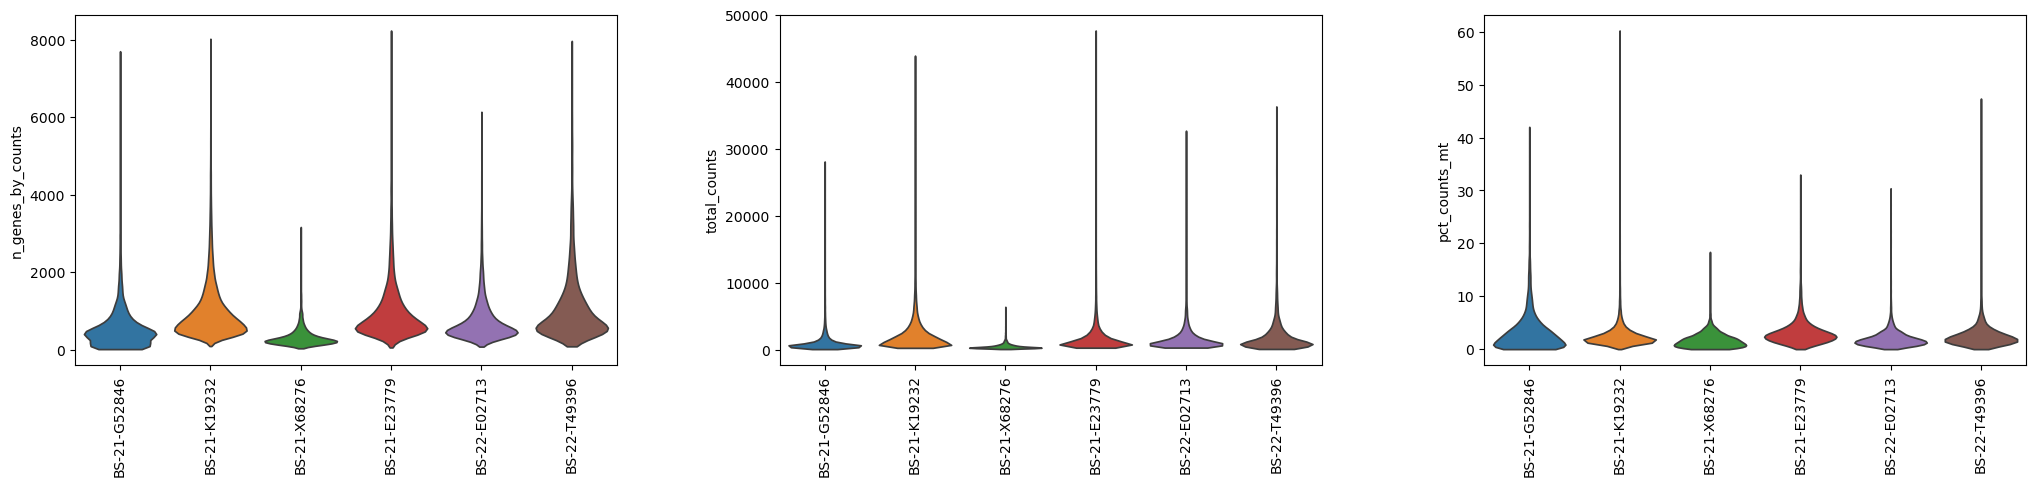

In [10]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    'sample_id',
    multi_panel=False,stripplot=False,rotation=90
)

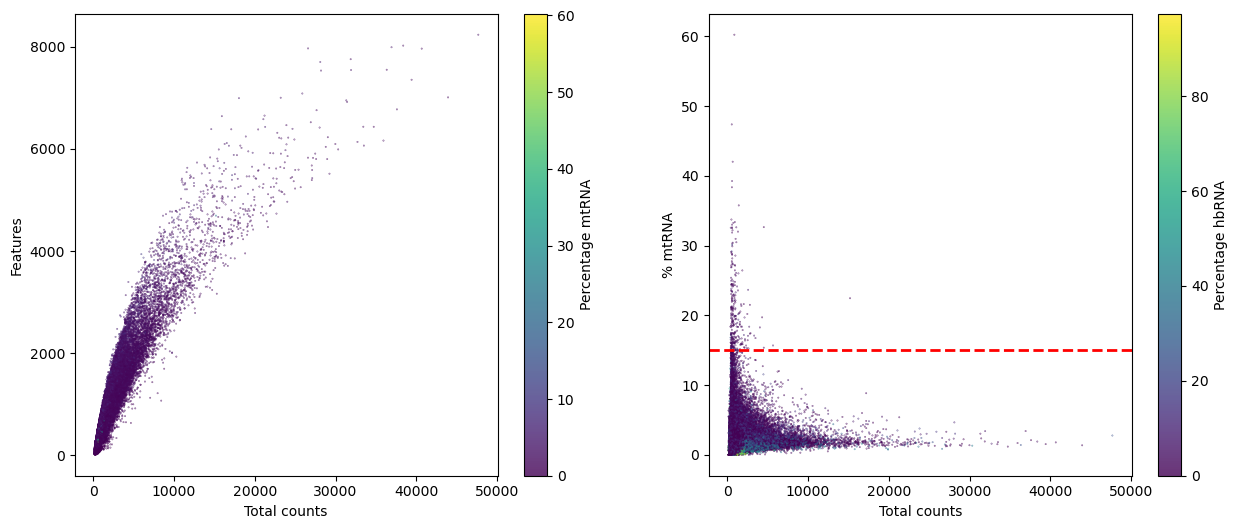

In [11]:
meta
fig, axes = plt.subplots(1,2,figsize=(15,6))
# sns.scatterplot(x=meta['total_counts'],y=meta['n_genes_by_counts'], hue=meta['pct_counts_mt'], ax=axes[0])
# sns.scatterplot(x=meta['total_counts'],y=meta['pct_counts_mt'], hue=meta['pct_counts_hb'], ax=axes[1])


# Create scatter plot
scatter = axes[0].scatter(x=meta['total_counts'],y=meta['n_genes_by_counts'], c=meta['pct_counts_mt'], alpha=0.8,s=.1)
# Add colorbar
cbar = plt.colorbar(scatter, ax=axes[0])
cbar.set_label('Percentage mtRNA')
axes[0].set_ylabel('Features')
axes[0].set_xlabel('Total counts')


scatter_mt = axes[1].scatter(x=meta['total_counts'],y=meta['pct_counts_mt'], c=meta['pct_counts_hb'], alpha=0.8,s=.1)
axes[1].axhline(15, color='red', linestyle='--', linewidth=2)
cbar = plt.colorbar(scatter_mt, ax=axes[1])
cbar.set_label('Percentage hbRNA')
axes[1].set_ylabel('% mtRNA')
axes[1].set_xlabel('Total counts')


plt.show()

In [10]:
mtRNA=10
retrieved = adata[adata.obs['pct_counts_mt'] < mtRNA].shape[0]
proportion_retrieved= (retrieved/adata.shape[0])*100
Markdown(f"""
### mtRNA

Setting the threshold for mtRNA equal to {mtRNA}%, the total number of save retrieved cells is: {retrieved}, {round(proportion_retrieved,2)}% of the total

""")


### mtRNA

Setting the threshold for mtRNA equal to 10%, the total number of save retrieved cells is: 53273, 98.27% of the total



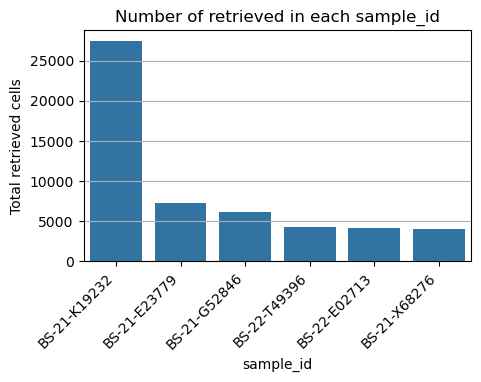

In [13]:
meta['retrieve_mt'] = meta['pct_counts_mt'] < 10
df=meta.groupby('sample_id').agg({
    'retrieve_mt': 'sum'
})
df['retrieve_prop'] = df['retrieve_mt']/ meta['sample_id'].value_counts()
df = df.reset_index()

plt.figure(figsize=(5,3))
sns.barplot(data=df,x='sample_id',y='retrieve_mt',order=df.sort_values('retrieve_mt', ascending=False).sample_id)
plt.ylabel('Total retrieved cells')
plt.grid(axis='y') 
plt.title('Number of retrieved in each sample_id')
plt.xticks(rotation=45, ha='right')
plt.show()

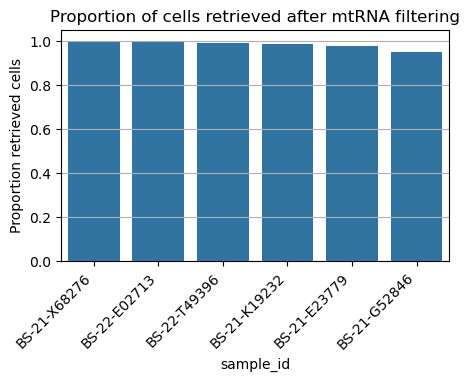

In [14]:
df['retrieve_mt'] = (df['retrieve_mt']/meta['sample_id'].value_counts())*100

plt.figure(figsize=(5,3))
sns.barplot(data=df,x='sample_id',y='retrieve_prop',order=df.sort_values('retrieve_prop', ascending=False).sample_id)

plt.ylabel('Proportion retrieved cells')
plt.grid(axis='y') 
plt.title('Proportion of cells retrieved after mtRNA filtering')
plt.xticks(rotation=45, ha='right')
plt.show()


### Genes per cell

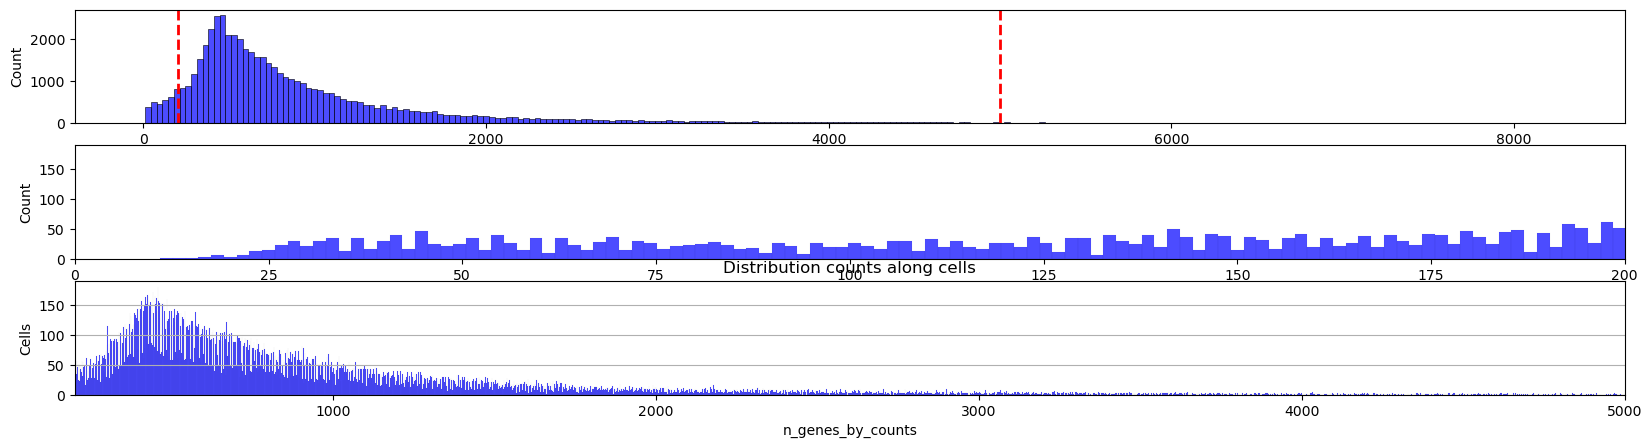

In [15]:
fig, axes = plt.subplots(3,1,figsize=(20, 5))
sns.histplot(meta['n_genes_by_counts'], kde=False, alpha=.7, color='blue', edgecolor='black',ax=axes[0])
sns.histplot(meta['n_genes_by_counts'],bins=5000, kde=False, alpha=.7, color='blue', edgecolor='black',ax=axes[1])
axes[1].set_xlim([0,200])
sns.histplot(meta['n_genes_by_counts'],bins=5000, kde=False, alpha=.7, color='blue', edgecolor='black',ax=axes[2])
axes[2].set_xlim([200,5000])
axes[0].axvline(200, color='red', linestyle='--', linewidth=2)
axes[0].axvline(5000, color='red', linestyle='--', linewidth=2)

plt.ylabel('Cells')
plt.grid(axis='y') 
plt.title('Distribution counts along cells')

plt.show()

# Apply basic filters:


filtering cells by basic thresholds:
- 10% mtRNA
- min 200 genes
- max 5000 genes

In [17]:
max_rna=10
min_genes=50
max_genes=4000


In [38]:
adata_clean = adata[(adata.obs['pct_counts_mt']<max_rna)&(adata.obs['n_genes_by_counts']>min_genes)&(adata.obs['n_genes_by_counts']<max_genes)]
meta_clean = adata_clean.obs
adata_clean

View of AnnData object with n_obs × n_vars = 51609 × 18129
    obs: 'og_barcodes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_ig', 'log1p_total_counts_ig', 'pct_counts_ig', 'Scrublet_score', 'Scrublet_doublet', 'SCDS_cxds_score', 'SCDS_bcds_score', 'SCDS_hybrid_score', 'scDblFinder_score', 'scDblFinder_class', 'sample_id', 'thr', 'retrieve_mt'

In [39]:
Markdown(f"""
- Number of cell retrieved after apply basic filters: {adata_clean.shape[0]}
- Proportion of retrieved cells: {round(adata_clean.shape[0]/adata.shape[0],2)}
- Average number of cells per sample: {round(meta_clean['sample_id'].value_counts().mean(),2)}
- Median number of cells per sample: {meta_clean['sample_id'].value_counts().median()}
""")


- Number of cell retrieved after apply basic filters: 51609
- Proportion of retrieved cells: 0.95
- Average number of cells per sample: 8601.5
- Median number of cells per sample: 4598.5


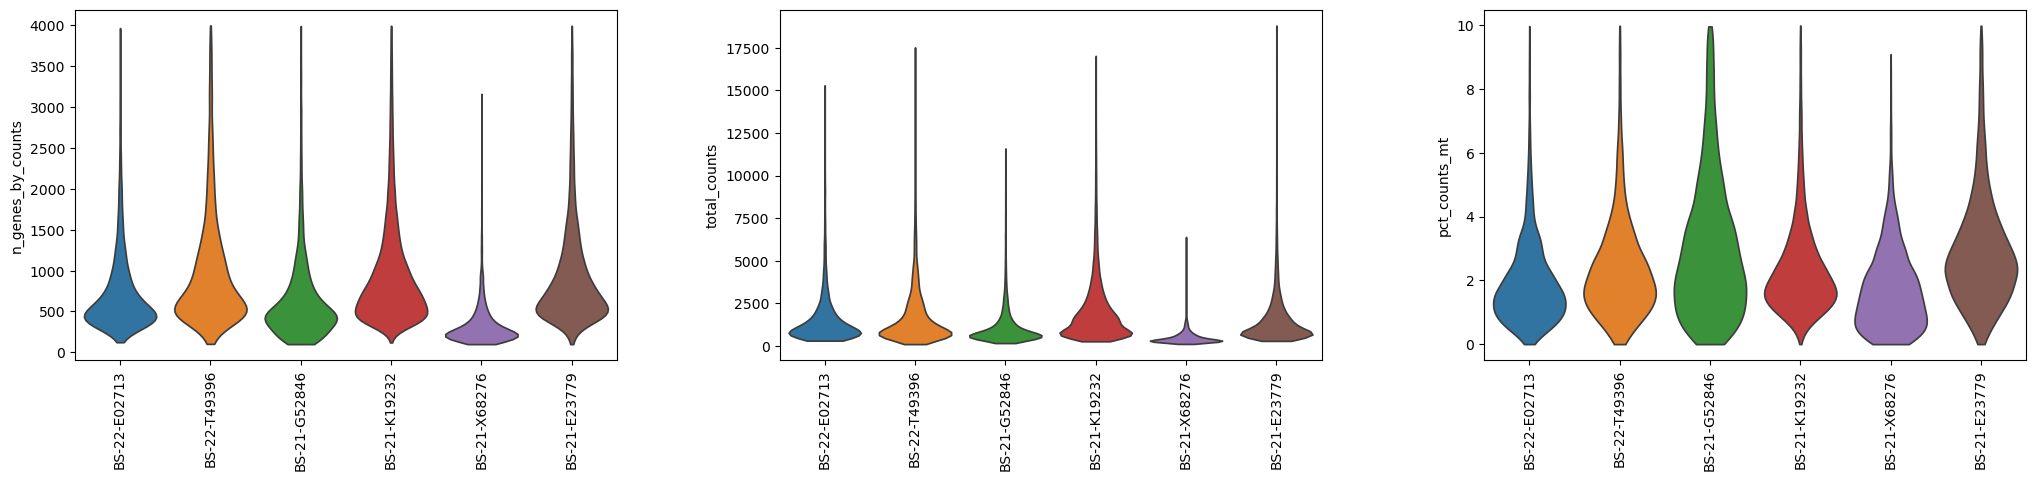

In [40]:
sc.pl.violin(
    adata_clean,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    'sample_id',
    multi_panel=False,stripplot=False,rotation=90
)

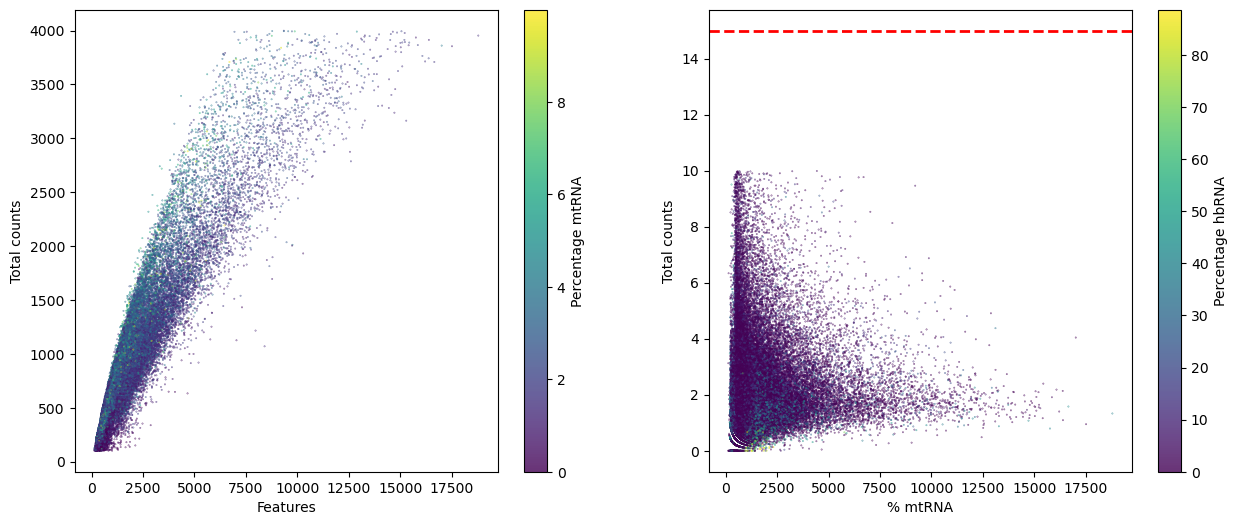

In [20]:
meta_clean = adata_clean.obs
fig, axes = plt.subplots(1,2,figsize=(15,6))
# sns.scatterplot(x=meta['total_counts'],y=meta['n_genes_by_counts'], hue=meta['pct_counts_mt'], ax=axes[0])
# sns.scatterplot(x=meta['total_counts'],y=meta['pct_counts_mt'], hue=meta['pct_counts_hb'], ax=axes[1])

# Create scatter plot
scatter = axes[0].scatter(x=meta_clean['total_counts'],y=meta_clean['n_genes_by_counts'], c=meta_clean['pct_counts_mt'], alpha=0.8,s=.1)
# Add colorbar
cbar = plt.colorbar(scatter, ax=axes[0])
cbar.set_label('Percentage mtRNA')
axes[0].set_ylabel('Total counts')
axes[0].set_xlabel('Features')


scatter_mt = axes[1].scatter(x=meta_clean['total_counts'],y=meta_clean['pct_counts_mt'], c=meta_clean['pct_counts_hb'], alpha=0.8,s=.1)
axes[1].axhline(15, color='red', linestyle='--', linewidth=2)
cbar = plt.colorbar(scatter_mt, ax=axes[1])
cbar.set_label('Percentage hbRNA')
axes[1].set_ylabel('Total counts')
axes[1].set_xlabel('% mtRNA')

plt.show()

# Dim reduction and plot

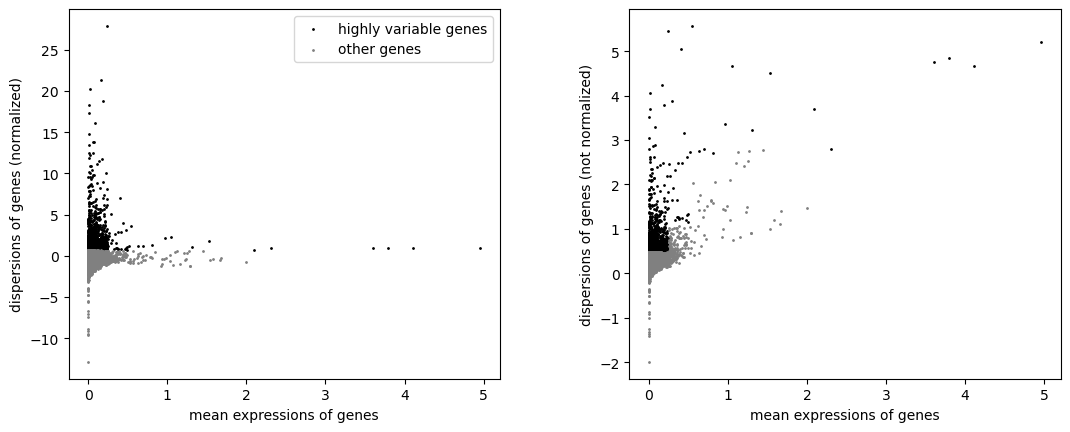

In [41]:
# Saving count data
adata_clean.layers["counts"] = adata_clean.X.copy()
# Normalizing to median total counts
sc.pp.normalize_total(adata_clean)
# Logarithmize the data
sc.pp.log1p(adata_clean)
sc.pp.highly_variable_genes(adata_clean, n_top_genes=2000)
sc.pl.highly_variable_genes(adata_clean)

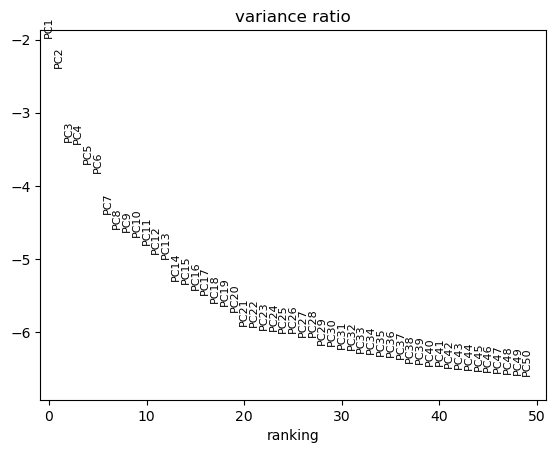

In [42]:
sc.tl.pca(adata_clean,use_highly_variable=True,random_state=12345)
sc.pl.pca_variance_ratio(adata_clean, n_pcs=50, log=True)

In [43]:
# Batch correct PCs with Harmony
import harmonypy as hm
ho = hm.run_harmony(adata_clean.obsm['X_pca'], adata_clean.obs, ['sample_id'])

2025-03-28 18:52:33,771 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-03-28 18:52:54,675 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-03-28 18:52:55,114 - harmonypy - INFO - Iteration 1 of 10
2025-03-28 18:53:25,466 - harmonypy - INFO - Iteration 2 of 10
2025-03-28 18:53:52,467 - harmonypy - INFO - Iteration 3 of 10
2025-03-28 18:54:18,313 - harmonypy - INFO - Iteration 4 of 10
2025-03-28 18:54:43,755 - harmonypy - INFO - Iteration 5 of 10
2025-03-28 18:55:10,838 - harmonypy - INFO - Iteration 6 of 10
2025-03-28 18:55:42,847 - harmonypy - INFO - Iteration 7 of 10
2025-03-28 18:56:11,451 - harmonypy - INFO - Iteration 8 of 10
2025-03-28 18:56:39,717 - harmonypy - INFO - Iteration 9 of 10
2025-03-28 18:57:06,727 - harmonypy - INFO - Iteration 10 of 10
2025-03-28 18:57:57,544 - harmonypy - INFO - Stopped before convergence


In [44]:
adata_clean.obsm['X_pca_harmony'] = np.transpose(ho.Z_corr)

In [45]:
sc.pp.neighbors(adata_clean,n_pcs=50,random_state=12345,use_rep='X_pca_harmony')

In [52]:
sc.pp.neighbors(adata_clean,n_pcs=50,random_state=12345,use_rep='X_pca_harmony')sc.tl.umap(adata_clean,random_state=12345)

In [50]:
sc.tl.leiden(adata_clean,resolution=0.5)

In [48]:
adata_clean

AnnData object with n_obs × n_vars = 51609 × 18129
    obs: 'og_barcodes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_ig', 'log1p_total_counts_ig', 'pct_counts_ig', 'Scrublet_score', 'Scrublet_doublet', 'SCDS_cxds_score', 'SCDS_bcds_score', 'SCDS_hybrid_score', 'scDblFinder_score', 'scDblFinder_class', 'sample_id', 'thr', 'retrieve_mt', 'leiden'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'sample_id_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

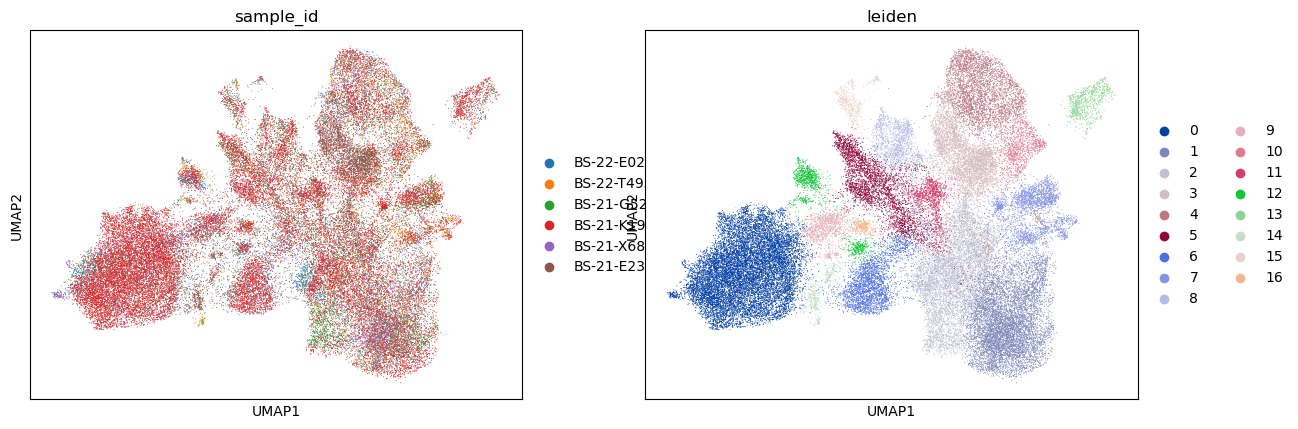

In [53]:
sc.pl.umap(
    adata_clean,
    color=['sample_id','leiden'],
    size=2,ncols=2
)

In [60]:
for i in ['Scrublet_doublet']:
    adata.obs[i] = adata.obs[i].astype(str)
    adata_clean.obs[i] = adata_clean.obs[i].astype(str)

adata.write('../out/single_cell_object/adata_full.h5ad',compression='gzip')
adata_clean.write('../out/single_cell_object/adata_clean.h5ad',compression='gzip')